# Tutorial: K562 HCT116 SP1 single-cell callingcards data. 
In some situations, transcription factor is added to the sample to study its specific functions. Wild type data might be needed while analyzing.

 The data is from [Moudgil et al., Cell. (2020)](https://doi.org/10.1016/j.cell.2020.06.037).

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc



Read single-cell calling cards ccf data. The columns indecates the chromosome, the start, end point of each htop, read number, direction and cell barcodes.

In [2]:
exp_ccf = cc.datasets.SP1_K562HCT116_data(data = "experience_ccf")
exp_ccf

,0,1,2,3,4,5
0,chr1,16529,16533,163,-,GCTCCTAAGTACGTTC-1-1
1,chr1,29884,29888,10,+,CTCACACCAGACGCTC-1-1
2,chr1,29884,29888,155,+,TGGCCAGCACCCATTC-1-1
3,chr1,29884,29888,285,+,GTGGGTCCACGGCCAT-1-1
4,chr1,29884,29888,7,+,CGTCTACTCAACACGT-1-1
...,...,...,...,...,...,...
404670,chrY,57080855,57080859,7,+,GTAACGTAGTTACGGG-1-2
404671,chrY,57080855,57080859,9,+,TCAGCAAGTTGAACTC-1-2
404672,chrY,57145084,57145088,2,-,ACATACGTCGCGCCAA-1-1
404673,chrY,57148630,57148634,2,-,TATGCCCGTACAGTTC-1-1


In [3]:
bg_ccf = cc.datasets.SP1_K562HCT116_data(data = "background_ccf")
bg_ccf 

,0,1,2,3,4,5
0,chr1,30238,30242,3,+,TTTACTGCATAAAGGT-1-1
1,chr1,30355,30359,2,-,ATCACGAAGAGTAATC-1-1
2,chr1,30355,30359,70,+,TTGAACGCAAATCCGT-1-1
3,chr1,31101,31105,2,+,CCTCAGTCATCAGTAC-1-1
4,chr1,32116,32120,5,+,CTAGTGAAGACAAAGG-1-1
...,...,...,...,...,...,...
145154,chrY,57080210,57080214,9,-,AAGGAGCCAGTATAAG-1-1
145155,chrY,57087785,57087789,24,-,CGAGCCAGTCTCTCTG-1-1
145156,chrY,57144853,57144857,5,+,GAAGCAGTCCCATTTA-1-1
145157,chrY,57183772,57183776,2,-,TCTTTCCTCTTGCCGT-1-1


We now call the peaks under the backgroud of wild type to diagnose potential binding sites.

In [4]:
peak_data = cc.pp.callpeaks(exp_ccf, bg_ccf, method = "MACS2", reference = "hg38", pvalue_cutoffbg = 0.1, window_size = 2000, step_size = 500,
                  pvalue_cutoffTTAA = 0.001, lam_win_size = None,  pseudocounts = 0.1, record = True, save = "peak.bed")
peak_data

For the MACS2 method with background, [expdata, background, reference, pvalue_cutoffbg, pvalue_cutoffTTAA, lam_win_size, window_size, step_size, extend, pseudocounts, test_method, min_hops, record] would be utilized.


100%|██████████| 25/25 [01:55<00:00,  4.61s/it]


,Chr,Start,End,Center,Experiment Hops,Background Hops,Reference Hops,pvalue Reference,pvalue Background,Fraction Experiment,TPH Experiment,Fraction background,TPH background,TPH background subtracted
0,chr1,29684,30087,29884.0,6,0,1,1.186428e-10,1.546531e-04,0.000015,1482.671279,0.000000,0.000000,1482.671279
1,chr1,32831,34691,33358.0,61,15,16,0.000000e+00,5.615291e-02,0.000151,15073.824674,0.000103,10333.496373,4740.328301
2,chr1,36239,38107,37578.0,25,2,15,0.000000e+00,3.373058e-04,0.000062,6177.796998,0.000014,1377.799516,4799.997481
3,chr1,198893,201208,200869.0,30,2,11,0.000000e+00,1.298297e-05,0.000074,7413.356397,0.000014,1377.799516,6035.556881
4,chr1,203351,207161,205004.0,92,16,22,0.000000e+00,1.459710e-04,0.000227,22734.292951,0.000110,11022.396131,11711.896820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11904,chrY,16985442,16985845,16985642.0,5,0,2,1.939720e-09,4.678840e-03,0.000012,1235.559400,0.000000,0.000000,1235.559400
11905,chrY,19753311,19753714,19753511.0,36,0,1,0.000000e+00,2.553513e-15,0.000089,8896.027677,0.000000,0.000000,8896.027677
11906,chrY,21011133,21011828,21011333.0,5,0,4,2.869028e-09,4.678840e-03,0.000012,1235.559400,0.000000,0.000000,1235.559400
11907,chrY,24204955,24205358,24205155.0,5,0,1,1.578515e-09,4.678840e-03,0.000012,1235.559400,0.000000,0.000000,1235.559400



In order to choose good paramenters/method for peak calling. Taking a look at the genome is strongly adviced.

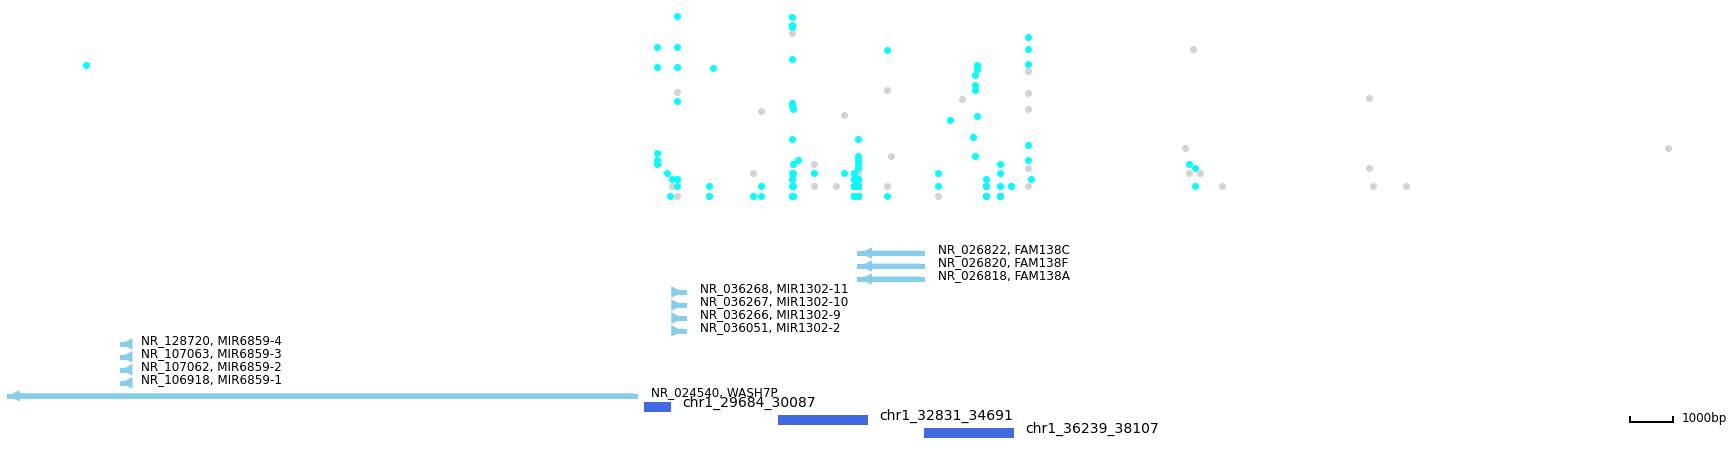

In [5]:
cc.pl.draw_area("chr1",29684,38824,15000,peak_data,exp_ccf, "hg38", bg_ccf,
                figsize = (30,8),peak_line = 3,save = False, example_length = 1000)

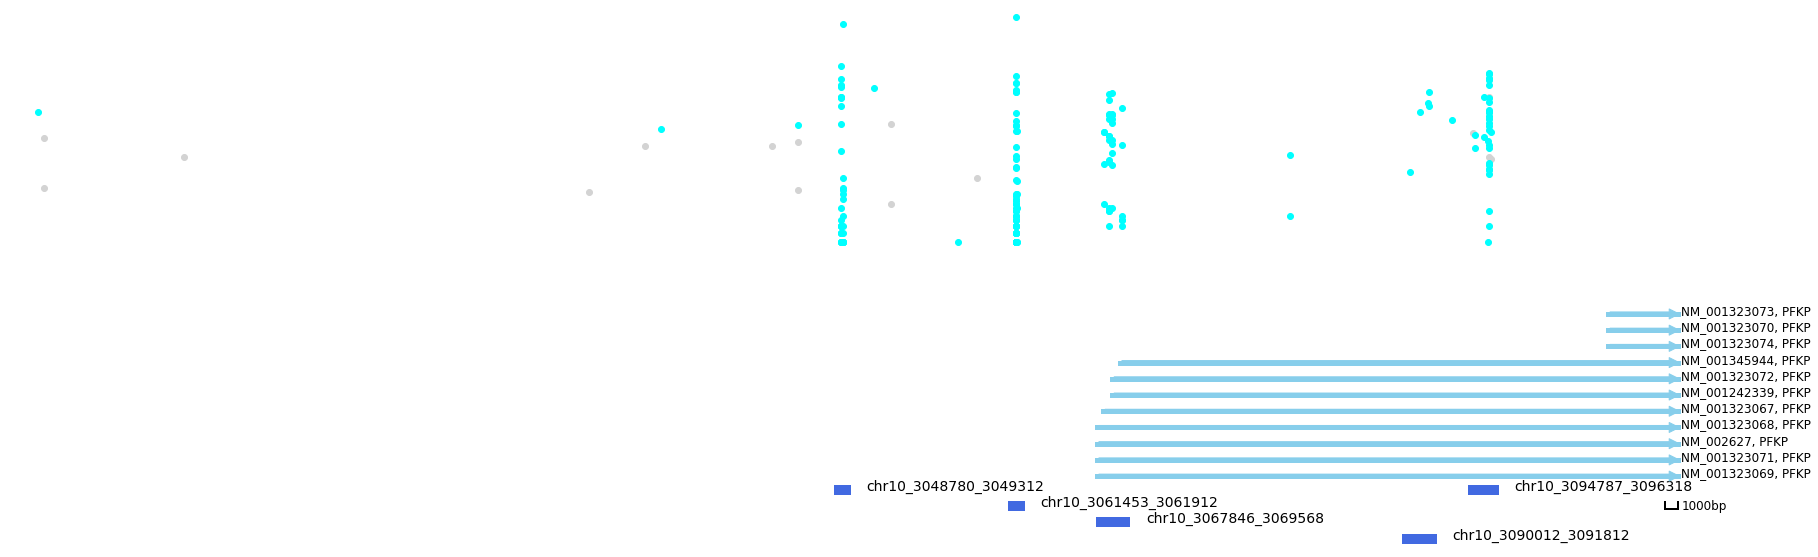

In [6]:
cc.pl.draw_area("chr10",3048452,3049913,60000,peak_data,exp_ccf, "hg38", bg_ccf,
                figsize = (30,10),peak_line = 4,save = False, example_length = 1000)

Find out the closest genes for each peak to annotate.

In [7]:
peak_annotation = cc.pp.annotation(peak_data, reference = "hg38")
peak_annotation = cc.pp.combine_annotation(peak_data,peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


,Chr,Start,End,Center,Experiment Hops,Background Hops,Reference Hops,pvalue Reference,pvalue Background,Fraction Experiment,TPH Experiment,Fraction background,TPH background,TPH background subtracted,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2
0,chr1,29684,30087,29884.0,6,0,1,1.186428e-10,1.546531e-04,0.000015,1482.671279,0.000000,0.000000,1482.671279,NR_036051,MIR1302-2,NR_024540,WASH7P
1,chr1,32831,34691,33358.0,61,15,16,0.000000e+00,5.615291e-02,0.000151,15073.824674,0.000103,10333.496373,4740.328301,NR_026818,FAM138A,NR_036051,MIR1302-2
2,chr1,36239,38107,37578.0,25,2,15,0.000000e+00,3.373058e-04,0.000062,6177.796998,0.000014,1377.799516,4799.997481,NR_026818,FAM138A,NR_036051,MIR1302-2
3,chr1,198893,201208,200869.0,30,2,11,0.000000e+00,1.298297e-05,0.000074,7413.356397,0.000014,1377.799516,6035.556881,NR_026823,FAM138D,NR_107063,MIR6859-3
4,chr1,203351,207161,205004.0,92,16,22,0.000000e+00,1.459710e-04,0.000227,22734.292951,0.000110,11022.396131,11711.896820,NR_026823,FAM138D,NR_107063,MIR6859-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11904,chrY,16985442,16985845,16985642.0,5,0,2,1.939720e-09,4.678840e-03,0.000012,1235.559400,0.000000,0.000000,1235.559400,NR_028083,FAM41AY1,NR_002160,FAM224B
11905,chrY,19753311,19753714,19753511.0,36,0,1,0.000000e+00,2.553513e-15,0.000089,8896.027677,0.000000,0.000000,8896.027677,NM_001146706,KDM5D,NR_045128,TXLNGY
11906,chrY,21011133,21011828,21011333.0,5,0,4,2.869028e-09,4.678840e-03,0.000012,1235.559400,0.000000,0.000000,1235.559400,NM_001039567,RPS4Y2,NM_001282471,PRORY
11907,chrY,24204955,24205358,24205155.0,5,0,1,1.578515e-09,4.678840e-03,0.000012,1235.559400,0.000000,0.000000,1235.559400,NR_001555,GOLGA2P2Y,NR_001554,CSPG4P1Y


Read the barocede file.

In [8]:
barcodes = cc.datasets.SP1_K562HCT116_data(data = "barcodes")
barcodes

,Index,cluster
0,AAACCTGAGAAAGTGG-1-2,HCT116
1,AAACCTGAGACCGGAT-1-1,K562
2,AAACCTGAGACTAGAT-1-2,HCT116
3,AAACCTGAGAGCTTCT-1-2,HCT116
4,AAACCTGAGAGTACCG-1-2,HCT116
...,...,...
52207,TTTGTCATCTCGATGA-1-1,K562
52208,TTTGTCATCTCTAAGG-1-1,K562
52209,TTTGTCATCTGGAGCC-1-2,HCT116
52210,TTTGTCATCTTGGGTA-1-2,HCT116


Use ccf data, peak data and barcodes data to make a cell by peak anndata object.

In [9]:
adata_ccf = cc.pp.makeAnndata(exp_ccf, peak_annotation, barcodes)
adata_ccf

AnnData object with n_obs × n_vars = 51965 × 11909
    obs: 'cluster'
    var: 'Chr', 'Start', 'End', 'Center', 'Experiment Hops', 'Background Hops', 'Reference Hops', 'pvalue Reference', 'pvalue Background', 'Fraction Experiment', 'TPH Experiment', 'Fraction background', 'TPH background', 'TPH background subtracted', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

Although one peak should have many htops, but there is a chance that all the cells from the peak was filtered by the RNA preprocesssing. In this case, we advice to filter the peaks. 

In [10]:
cc.pp.filter_peaks(adata_ccf, min_counts=5)
adata_ccf

AnnData object with n_obs × n_vars = 51965 × 11909
    obs: 'cluster'
    var: 'Chr', 'Start', 'End', 'Center', 'Experiment Hops', 'Background Hops', 'Reference Hops', 'pvalue Reference', 'pvalue Background', 'Fraction Experiment', 'TPH Experiment', 'Fraction background', 'TPH background', 'TPH background subtracted', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2', 'n_counts'

In [11]:
cc.pp.filter_peaks(adata_ccf, min_cells=5)
adata_ccf

AnnData object with n_obs × n_vars = 51965 × 11901
    obs: 'cluster'
    var: 'Chr', 'Start', 'End', 'Center', 'Experiment Hops', 'Background Hops', 'Reference Hops', 'pvalue Reference', 'pvalue Background', 'Fraction Experiment', 'TPH Experiment', 'Fraction background', 'TPH background', 'TPH background subtracted', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2', 'n_counts', 'n_cells'

Differential binding analysis would find out the significant binding for each cluster.

In [12]:
cc.tl.rank_peak_groups(adata_ccf,"cluster",method = 'fisher_exact',key_added = 'fisher_exact')

Plot the results for differential binding analysis.

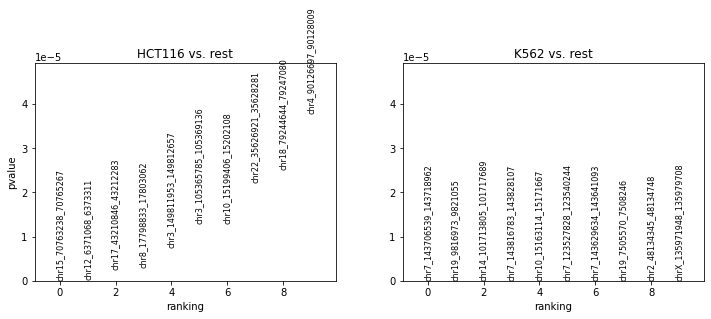

In [13]:
cc.pl.rank_peak_groups(adata_ccf, key = 'fisher_exact')

Take a look at the genome for highly differentiated peaks is strongly adviced.

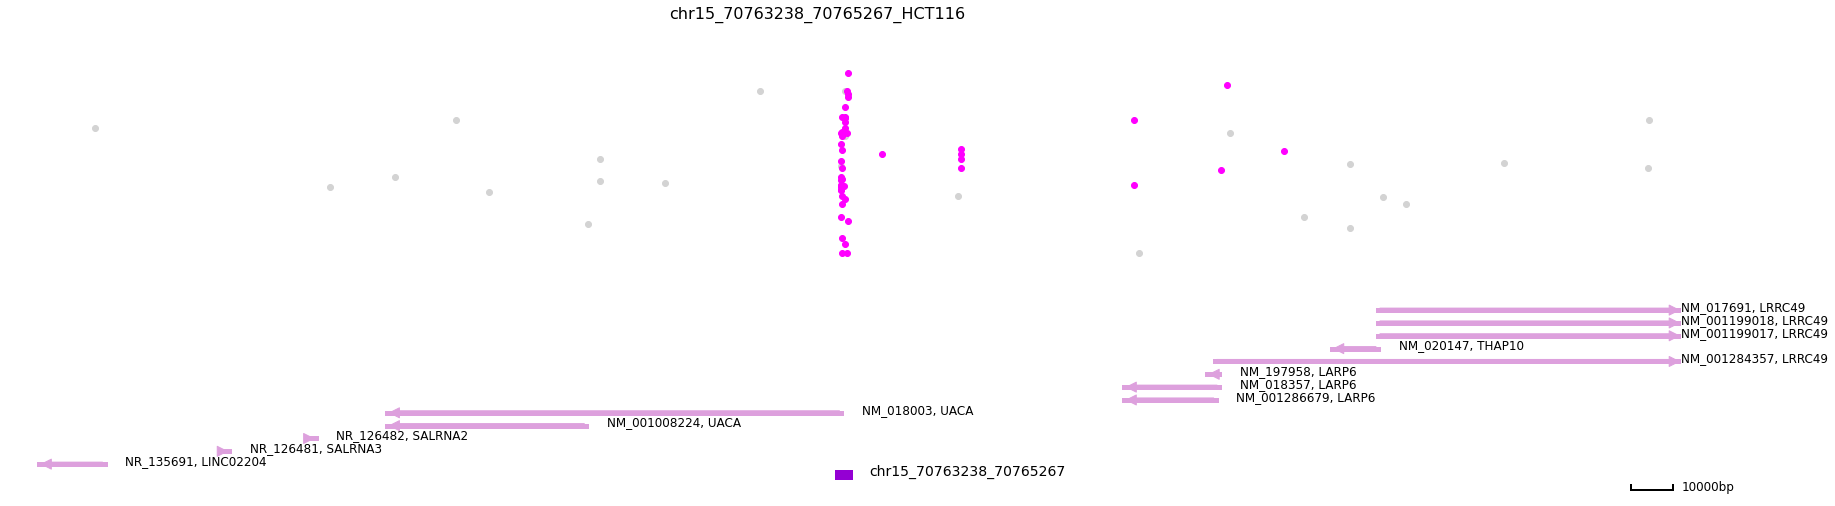

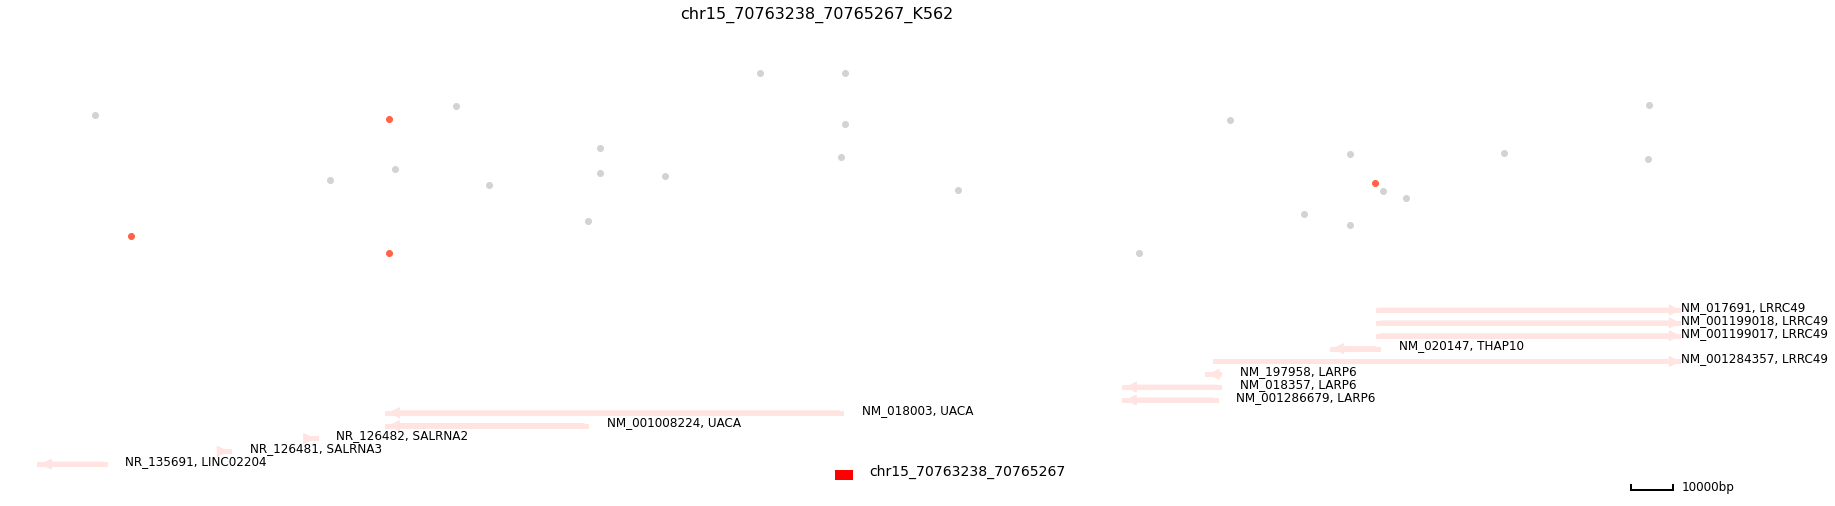

In [14]:
cc.pl.draw_area("chr15",70763238,70765267,200000,peak_data,exp_ccf,"hg38",adata = adata_ccf, background = bg_ccf,
                name = "HCT116",key ='cluster',figsize = (30,8),peak_line = 4,color = "purple",title = "chr15_70763238_70765267_HCT116")
cc.pl.draw_area("chr15",70763238,70765267,200000,peak_data,exp_ccf,"hg38",adata = adata_ccf, background = bg_ccf,
                name = "K562",key ='cluster',figsize = (30,8),peak_line = 4,color = "red",title = "chr15_70763238_70765267_K562")

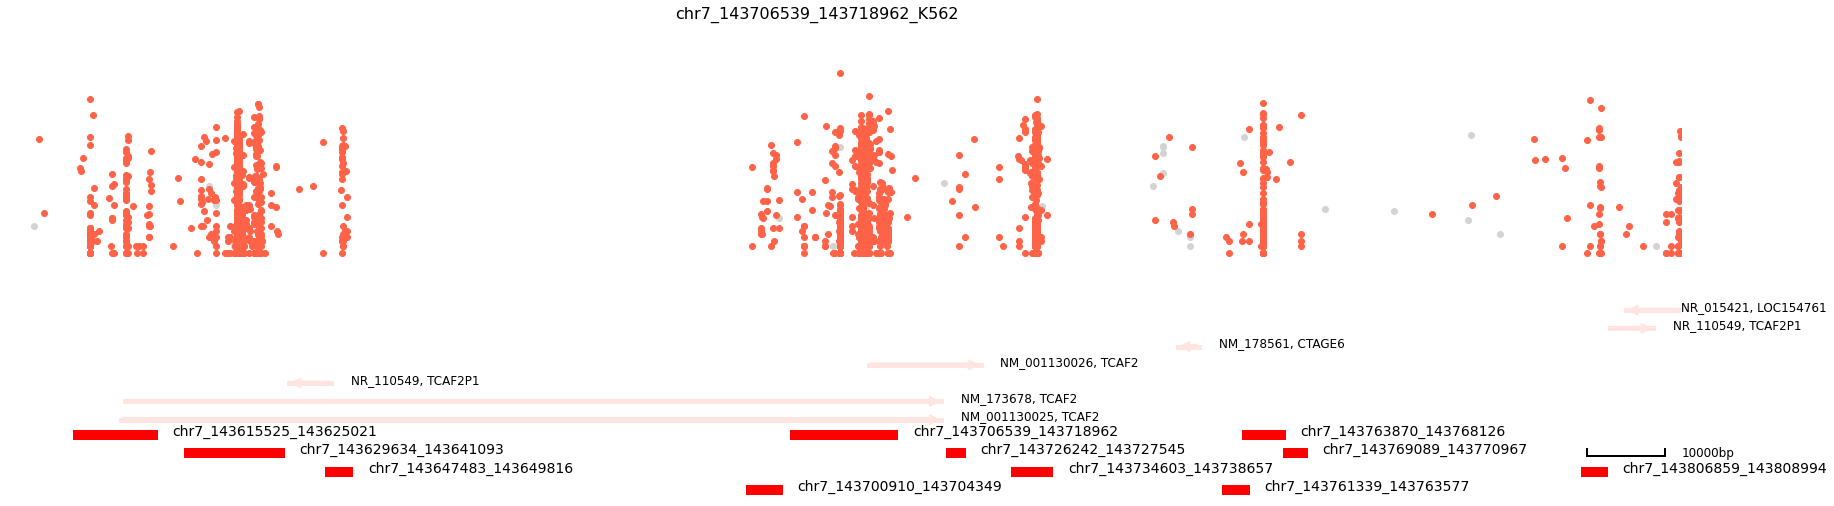

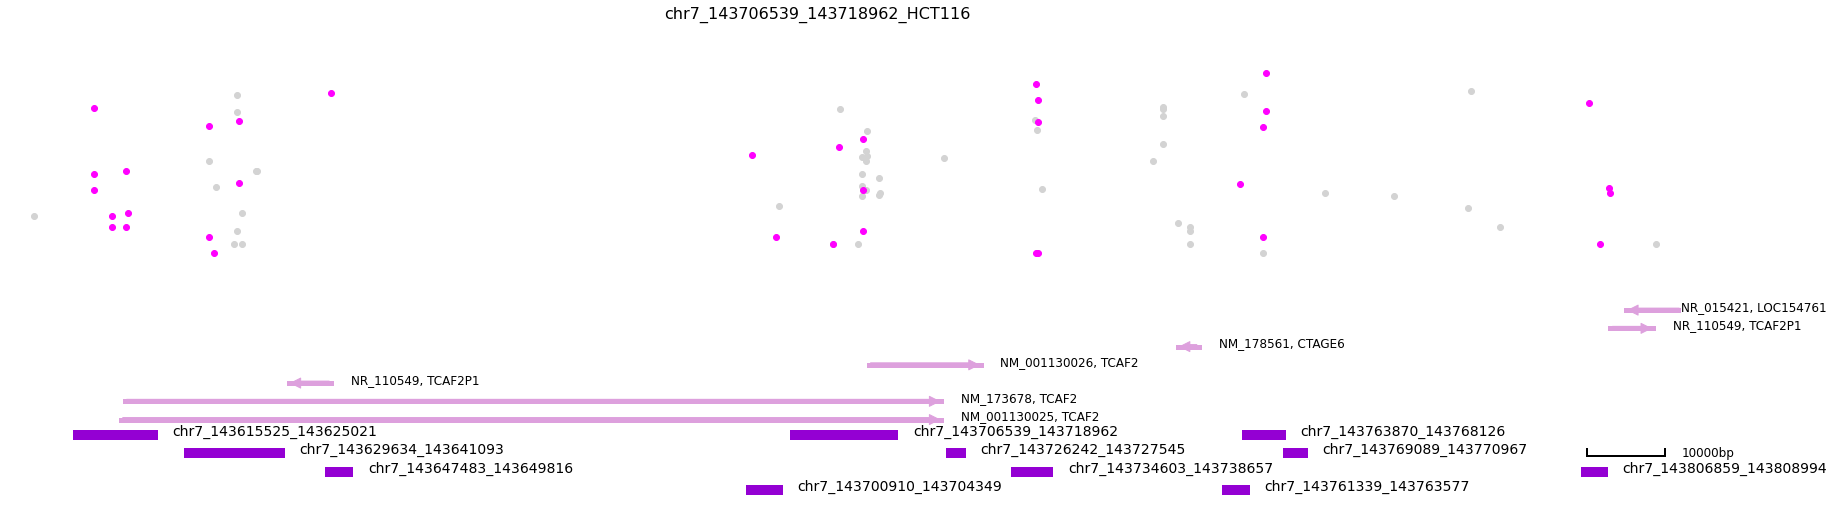

In [15]:
cc.pl.draw_area("chr7",143706539,143718962,100000,peak_data,exp_ccf,"hg38",adata = adata_ccf, background = bg_ccf,
                name = "K562",key ='cluster',figsize = (30,8),peak_line = 4,color = "red",title = "chr7_143706539_143718962_K562")
cc.pl.draw_area("chr7",143706539,143718962,100000,peak_data,exp_ccf,"hg38",adata = adata_ccf, background = bg_ccf,
                name = "HCT116",key ='cluster',figsize = (30,8),peak_line = 4,color = "purple",title = "chr7_143706539_143718962_HCT116")

Saved the file if needed.

In [16]:
adata_ccf.write("SP1_CCF.h5ad")